# Unified Post-Processing in DeePTB

This tutorial demonstrates the usage of the unified post-processing interface in DeePTB. The new `TBSystem` class acts as a central hub for managing your tight-binding model and structure, providing streamlined access to properties like Band Structure and Density of States (DOS).

## key Features
- **Centralized Control**: `TBSystem` manages both the atomic structure (`AtomicData`) and the Hamiltonian model (`HamiltonianCalculator`).
- **Property Accessors**: Intuitive access to properties via `system.band`, `system.dos`, etc.
- **Flexible Configuration**: Stateful configuration for K-paths and K-meshes.
- **Integration**: Seamlessly works with DeePTB models and ASE structures.

## 1. Setup and Initialization

First, we define the paths to our model checkpoint (`.pth`) and the atomic structure file (e.g., `POSCAR` or `.vasp`).

In [10]:
import os
import torch
import matplotlib.pyplot as plt
from dptb.postprocess.unified.system import TBSystem

# Define paths (Adjust to your local environment)
root_dir = os.path.abspath("../ToW90_PythTB") 
model_path = os.path.join(root_dir, "models", "nnsk.ep20.pth")
struct_path = os.path.join(root_dir, "silicon.vasp")


### Initialize TBSystem

We instantiate `TBSystem` by providing the data (structure) and the calculator (model). This automatically loads the model and prepares the system for calculation.

In [11]:
# Initialize the system
tbsys = TBSystem(data=struct_path, calculator=model_path)

print("TBSystem Initialized.")
# You can access the underlying ASE atoms object
print(f"Atoms: {tbsys.atoms}")

The model option atomic_radius in nnsk is not defined in input model_options, set to v1.


TBSystem Initialized.
Atoms: Atoms(symbols='Si2', pbc=True, cell=[[0.0, 2.71499984016137, 2.71499984016137], [2.71499984016137, 0.0, 2.71499984016137], [2.71499984016137, 2.71499984016137, 0.0]])


## 2. Band Structure Calculation

The `tbsys.band` accessor manages band structure calculations. You first configure the K-path and then compute the bands.

### Configure K-Path
We typically use the high-symmetry points. Here we define a path G-X-U-K-G-L-W-X using the `abacus` method convention.

In [12]:
kpath_config = {
    "method": "abacus",
    "kpath": [
        [0.000, 0.000, 0.000, 50], # G
        [0.500, 0.000, 0.500, 50], # X
        [0.625, 0.250, 0.625, 1],  # U
        [0.375, 0.375, 0.750, 50], # K
        [0.000, 0.000, 0.000, 50], # G 
        [0.500, 0.500, 0.500, 50], # L
        [0.500, 0.250, 0.750, 50], # W
        [0.500, 0.000, 0.500, 1]   # X
    ],
    "klabels": ["G", "X", "X/U", "K", "G", "L", "W", "X"]
}

# Set the configuration
tbsys.band.set_kpath(**kpath_config)

### Compute and Plot
Once configured, call `compute()` to run the model and get eigenvalues. The result is a `BandStructureData` object which supports plotting.

eig_solver is not set, using default 'torch'.


Eigenvalues shape: (302, 18)


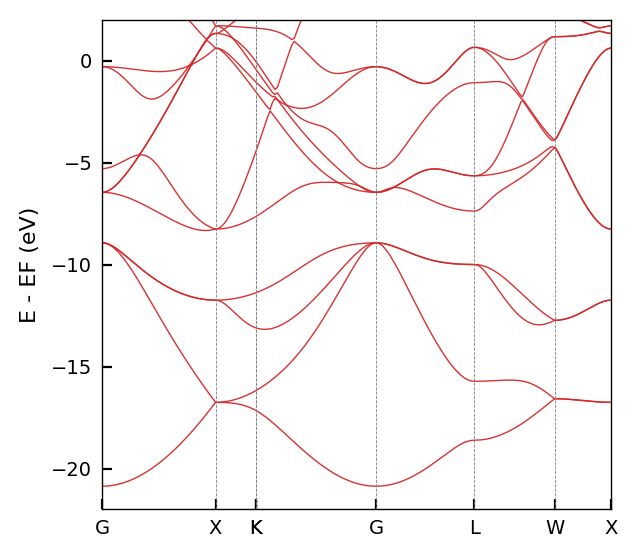

In [18]:
# Compute bands
bs_data = tbsys.band.compute()

# Access raw data if needed
print(f"Eigenvalues shape: {bs_data.eigenvalues.shape}")

# Plot the result
tbsys.band.plot(emin=-22, emax=2, filename="silicon_bands.png")

## 3. Density of States (DOS)

Similarly, the `tbsys.dos` accessor handles DOS and Projected DOS (PDOS).

### Configure K-Mesh and Energy Range
We set a uniform K-point mesh (e.g., 8x8x8) and define the energy range and smearing.

In [23]:
# 1. Define K-Mesh (eagerly generates k-points)
tbsys.dos.set_kpoints(kmesh=[35, 35, 35], is_gamma_center=True)

# 2. Configure DOS parameters
tbsys.dos.set_dos_config(
    erange=[-18, 0],
    npts=500,
    sigma=0.1, 
    pdos=True  # Calculate Projected DOS as well
)

### Compute and Plot DOS
Compute the DOS. If `pdos=True`, this might take slightly longer as it computes eigenvectors.

Total DOS shape: (500,)
PDOS shape: (500, 18) (Energy Points, Orbitals)


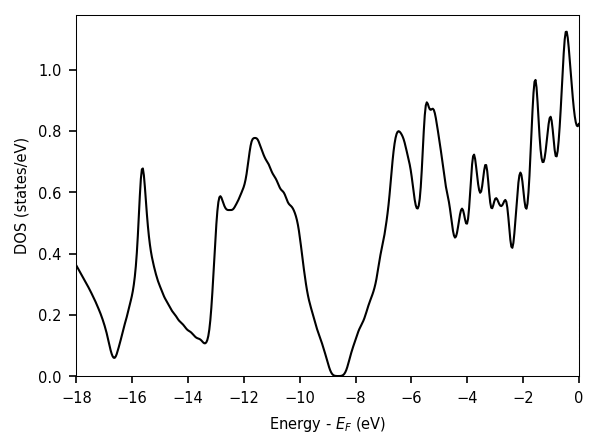

In [24]:
dos_data = tbsys.dos.compute()

print(f"Total DOS shape: {dos_data.total_dos.shape}")
if dos_data.pdos is not None:
    print(f"PDOS shape: {dos_data.pdos.shape} (Energy Points, Orbitals)")

# Plot DOS and PDOS
tbsys.dos.plot(plot_pdos=False, filename="silicon_dos.png")

## 4. Advanced Usage: Direct Hamiltonian Access

You can also access the underlying `HamiltonianCalculator` to get raw Hamiltonian matrices $H(k)$ or $H(R)$.

In [25]:
# Get H(k) at specific k-points
k_points = [[0, 0, 0], [0.5, 0.5, 0.5]] # G, L
hk, sk = tbsys.calculator.get_hk(tbsys.data, k_points=k_points)

print("Hamiltonian H(k) at G and L:")
print(hk.shape) # Expected: [2, Norb, Norb]

Hamiltonian H(k) at G and L:
torch.Size([2, 18, 18])


In [26]:
# Get Real-Space Hopping H(R)
hr_blocks, sr_blocks = tbsys.calculator.get_hr(tbsys.data)

print("Number of hopping blocks:", len(hr_blocks))
# hr_blocks is a dictionary or tensor map of hopping matrices

Number of hopping blocks: 36
